In [181]:
## Necessary imports
import numpy as np
import pandas as pd
import xgboost as xg
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

## Load testing database
import os
path = "..."
os.chdir(path)
df = pd.read_csv("Data_Test\U_A_TestBurgos.csv")

# Separate input and actual target variable
X_test = df[["Uwall", "Uroof", "Uwind", "g_glass","Q_int","Tsp","ACH","SSEcrgd", "Rc", "HDD_crgd"]]
y_test = df['Dem_crgd']

# Convert data to DMatrix
test_dmatrix = xg.DMatrix(X_test, y_test)

## Import pre-trainned model
pickled_model = pickle.load(open('model_All-HDD_Demand.pkl', 'rb'))
pred = pickled_model.predict(X_test)

## Error calculation
rmse = np.sqrt(MSE(y_test, pred))
mae = mean_absolute_error(y_test, pred)
mape = mean_absolute_percentage_error(y_test, pred)
print(f'MAE = {mae}')
print(f'MAPE = {mape}')
print(f'RMSE = {rmse}')


MAE = 16022009.268819444
MAPE = 0.45078002280518864
RMSE = 25250247.21554347


In [182]:
## Unit demand, prediction and error calculation  (unit: Wh/m2)
# Separate building case to building shape code 

Bld_case = df['Casos']
Bld_shape = Bld_case.str.split(".", expand = True)
Bld_shape.columns = ["Case", "Shape", "LocCode"]

# Vlookup the heated floor area (HFArea)  
Shape_code = pd.read_csv("Data_Train\Details_BuildingShape.csv")
Area_lookup = pd.merge(Bld_shape, Shape_code, on ='Shape', how ='left')

# Define the necessary array (HFA, RealDemadnd, PredictedDemand)
HFA = np.array(Area_lookup['HFArea'])
RealDemand = np.array(y_test)
PredDemand = np.array(pred) 
# Calculate the unit demand  (unit: Wh/m2)
URDemand = np.divide(RealDemand, HFA)
UPDemand = np.divide(PredDemand, HFA)

# Append all values
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    dframe = pd.DataFrame(Area_lookup)
    # Cumulative values and error
    dframe['Actual (kWh)'] = np.divide(y_test,1000)
    dframe['Prediction (kWh)'] = np.divide(pred,1000)
    Error = np.subtract(RealDemand, PredDemand)
    dframe['Error (kWh)'] = np.divide(Error,1000)
    # Unit values and error
    dframe['Actual (kWh/m2)'] = np.divide(URDemand,1000)
    dframe['Prediction (kWh/m2)'] = np.divide(UPDemand,1000)
    UError = np.subtract(URDemand, UPDemand)
    dframe['Error (kWh/m2)'] = np.divide(UError,1000)
    #print (dframe)

# Error calculation for unit heating demand
urmse = np.sqrt(MSE(URDemand, UPDemand))
umae = mean_absolute_error(URDemand, UPDemand)
umape = mean_absolute_percentage_error(URDemand, UPDemand)
print(f'Unit MAE = {umae}')
print(f'Unit MAPE = {umape}')
print(f'Unit RMSE = {urmse}')

Unit MAE = 12862.517513336328
Unit MAPE = 0.4507800228051886
Unit RMSE = 20255.55569307654


In [183]:
## Export prediction result: cumulative (unit: kWh)
result = dframe[["Case","Shape", "LocCode", "HFArea","Actual (kWh)","Prediction (kWh)", "Error (kWh)" ]]
result.to_csv(r'Result\All-HDD_testBUR_result.csv')
print ('Prediction result is exported')

## Export prediction result: unit value (unit: kWh/m2)
Uresult = dframe[["Case","Shape", "LocCode","HFArea", "Actual (kWh/m2)","Prediction (kWh/m2)", "Error (kWh/m2)" ]]
Uresult.to_csv(r'Result\All-HDD_testBUR_Uresult.csv')
print ('Unit prediction result is exported')

Prediction result is exported
Unit prediction result is exported


max y=  766572.625
min y=  -18776.296875
max x=  893390.01
min x=  1135.84
Regression line m and b:  0.8854139255459804 and 13413.468540552392
Prediction graph is saved


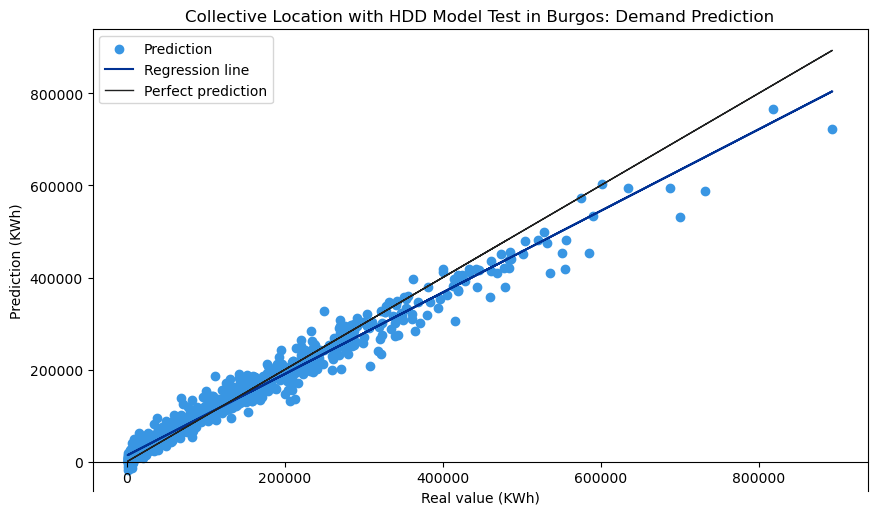

In [184]:
## Plot: real and predicted values  (unit: kWh)

source = result

# Define source, x and y data
# source = result
x1 = source['Actual (kWh)']
y1 = source['Prediction (kWh)']

# Data check
print('max y= ', y1.max())
print('min y= ', y1.min())
print('max x= ', x1.max())
print('min x= ', x1.min())

# Set graph size
fig = plt.figure(figsize =(10,6))

# Adjust x-axis to be at y=0
ax = fig.add_subplot(1, 1, 1)
ax.spines['bottom'].set_position('zero')

# Plot the data
plt.scatter(x1, y1, c='#3996e3', label='Prediction')
#plt.xlim(0,900000)

# Set axis label and title
plt.xlabel("Real value (KWh)")
plt.ylabel("Prediction (KWh)")
plt.title("Collective Location with HDD Model Test in Burgos: Demand Prediction")

# Create regression line
m, b = np.polyfit(x1, y1, 1)
plt.plot(x1, m*x1+b , c='#013294', lw=1.5, label='Regression line')
print ('Regression line m and b: ', m,'and', b)

# Create perfect prediction line (m=1)
plt.plot(x1, x1 , c='#202121', lw=1, label='Perfect prediction')

ax.legend()

# Export graph
plt.savefig(r'Result\All-HDD_testBUR_Prediction.png', format="png", dpi=800)
print ('Prediction graph is saved')


max y=  170225.914
min y=  -77453.84
max x=  893390.01
min x=  1135.84
Error graph is saved


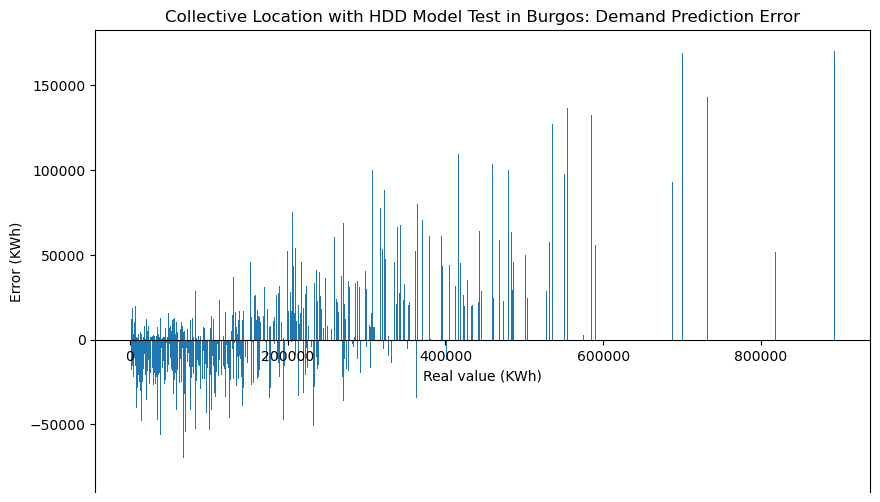

In [185]:
## Plot: prediction error and real value (unit: kWh)

# Define x and y data
# Error = real - prediction
x2 = source['Actual (kWh)']
y2 = source['Error (kWh)']

# Data check
print('max y= ', y2.max())
print('min y= ', y2.min())
print('max x= ', x2.max())
print('min x= ', x2.min())

# Set graph size
fig = plt.figure(figsize =(10,6))

# Adjust x-axis to be at y=0
ax = fig.add_subplot(1, 1, 1)
ax.spines['bottom'].set_position('zero')

# Plot the data
plt.bar(x2, y2, width=1000)
#plt.xlim(0,900000)
#plt.ylim(-350000, 350000)

# Set axis label and title
plt.xlabel("Real value (KWh)")
plt.ylabel("Error (KWh)")
plt.title("Collective Location with HDD Model Test in Burgos: Demand Prediction Error")

# Export graph
plt.savefig(r'Result\All-HDD_testBUR_Error.png', format="png", dpi=800)
print ('Error graph is saved')

max y=  275.9019304760949
min y=  -11.94185370569417
max x=  249.14624109204055
min x=  0.46864657943675087
Regression line m and b:  0.925368841861099 and 10.360269715131611
Unit prediction graph is saved


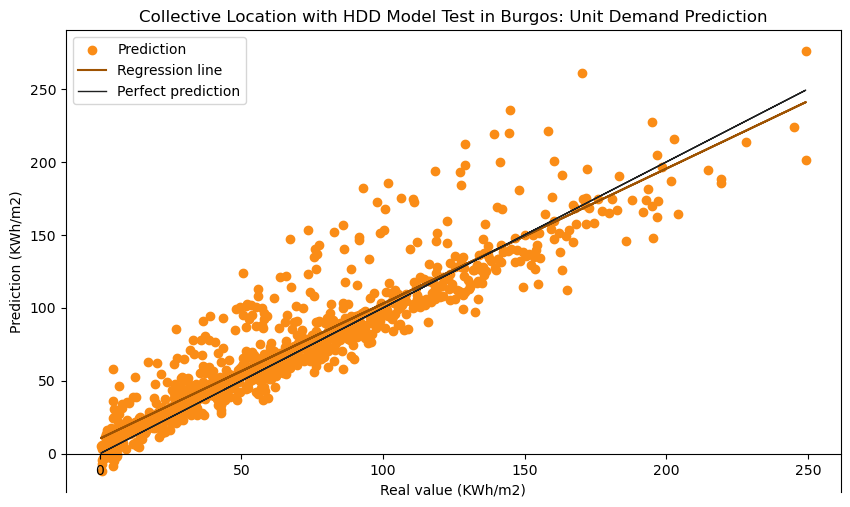

In [186]:
## Plot: unit real and predicted values  (unit: kWh/m2)

# Define source, x and y data
usource = Uresult
ux1 = usource['Actual (kWh/m2)']
uy1 = usource['Prediction (kWh/m2)']

# Data check
print('max y= ', uy1.max())
print('min y= ', uy1.min())
print('max x= ', ux1.max())
print('min x= ', ux1.min())

# Set graph size
fig = plt.figure(figsize =(10,6))

# Adjust x-axis to be at y=0
ax = fig.add_subplot(1, 1, 1)
ax.spines['bottom'].set_position('zero')

# Plot the data
plt.scatter(ux1, uy1, c='#fa8c16', label='Prediction')

# Set axis label and title
plt.xlabel("Real value (KWh/m2)")
plt.ylabel("Prediction (KWh/m2)")
plt.title("Collective Location with HDD Model Test in Burgos: Unit Demand Prediction")

# Create regression line
m, b = np.polyfit(ux1, uy1, 1)
plt.plot(ux1, m*ux1+b , c='#9e5302', lw=1.5, label='Regression line')
print ('Regression line m and b: ', m,'and', b)

# Create perfect prediction line (m=1)
plt.plot(ux1, ux1 , c='#202121', lw=1, label='Perfect prediction')

ax.legend()

# Export graph
plt.savefig(r'Result\All-HDD_testBUR_UPrediction.png', format="png", dpi=800)
print ('Unit prediction graph is saved')


max y=  52.856054066713504
min y=  -90.76902881129557
max x=  249.14624109204055
min x=  0.46864657943675087
Unit error graph is saved


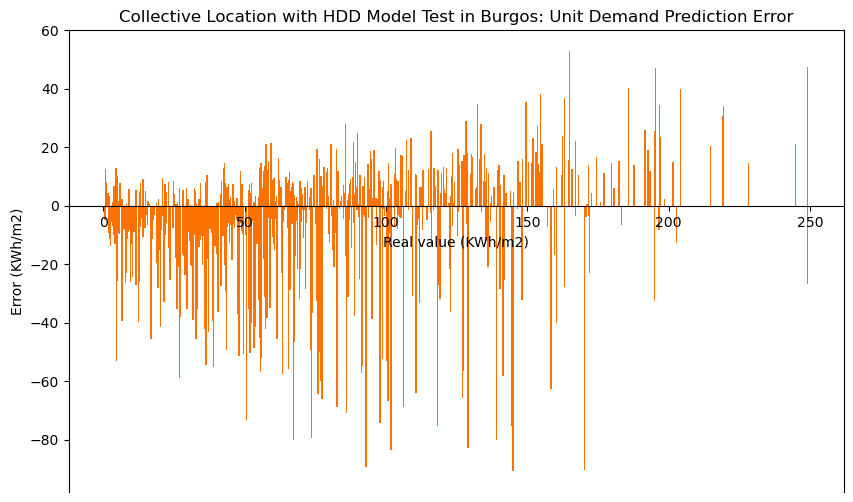

In [187]:
## Plot: unit prediction error and real value (unit: kWh)

# Define x and y data
# Error = real - prediction
ux2 = usource['Actual (kWh/m2)']
uy2 = usource['Error (kWh/m2)']

# Data check
print('max y= ', uy2.max())
print('min y= ', uy2.min())
print('max x= ', ux2.max())
print('min x= ', ux2.min())

# Set graph size
fig = plt.figure(figsize =(10,6))

# Adjust x-axis to be at y=0
ax = fig.add_subplot(1, 1, 1)
ax.spines['bottom'].set_position('zero')

# Plot the data
plt.bar(ux2, uy2, color='#fc7303', width=0.5)
#plt.xlim(0,610000)
#plt.ylim(-350000, 350000)

# Set axis label and title
plt.xlabel("Real value (KWh/m2)")
plt.ylabel("Error (KWh/m2)")
plt.title("Collective Location with HDD Model Test in Burgos: Unit Demand Prediction Error")

# Export graph
plt.savefig(r'Result\All-HDD_testBUR_UError.png', format="png", dpi=800)
print ('Unit error graph is saved')